## Graph Base Data Coding Tasks

1. SNAP data statistics and visualization  
2. CORA data exploration 

## 1. SNAP Exploration

Goals 
- Visualize Degree Distribution
- Create Adjacency Matrix, then visualize connections 
- Calculate Average Path Length
- With Adjacency Matrix, observe connectedness
- Calculate Cluster Coefficient for the graph 
- Visualize the Graph with networkx

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
import json

Start with Twitch Data

In [2]:
twitch_edges = pd.read_csv("../data/raw/snap/twitch/ENGB/musae_ENGB_edges.csv") # get edges, skip 1 to skip header
twitch_target = pd.read_csv("../data/raw/snap/twitch/ENGB/musae_ENGB_target.csv") # get target
twitch_target = twitch_target.set_index('new_id')
# get features
with open("../data/raw/snap/twitch/ENGB/musae_ENGB_features.json", "r") as file: 
    twitch_features = json.loads(file.read())

In [13]:
# reformat dataframe into array for faster speed
twitch_nodes = twitch_target.index.unique().to_numpy()

try: 
    twitch_edges = twitch_edges.to_numpy(dtype='int')
except: 
    pass
twitch_edges[:5]

array([[6194,  255],
       [6194,  980],
       [6194, 2992],
       [6194, 2507],
       [6194,  986]])

In [14]:
# populate graph with networkx 
def get_graph(nodes, edges): 
    """Populate and return a graph object"""
    graph = nx.Graph()
    graph.add_nodes_from(nodes)
    graph.add_edges_from(edges)
    return graph 


twitch = get_graph(twitch_nodes, twitch_edges)

In [23]:
# report on average degree, network diameter, average clustering coefficient
def graph_count(graph: nx.Graph):
    """Generate a printed report of general graph statistics"""
    degrees = np.array([degree for node, degree in graph.degree()])
    print(f"There are {graph.number_of_nodes()} nodes.")
    print(f"There are {graph.number_of_edges()} edges.")
    print(f"Average shortest path length {nx.average_shortest_path_length(graph)}")
    print(f"Average degree of the graph is {np.mean(degrees)}.")
    print(f"Network diameter is {nx.diameter(graph)}")
    print(f"Average clustering coefficient is {nx.average_clustering(graph)}.")


graph_count(twitch)

There are 7126 nodes.
There are 35324 edges.
Average shortest path length 3.6776157289097005
Average degree of the graph is 9.914117316867808.
Network diameter is 10
Average clustering coefficient is 0.13092821901472038.


Most probable degree: (2, 0.16292450182430537).
Least probable degree: (72, 0.000140331181588549).


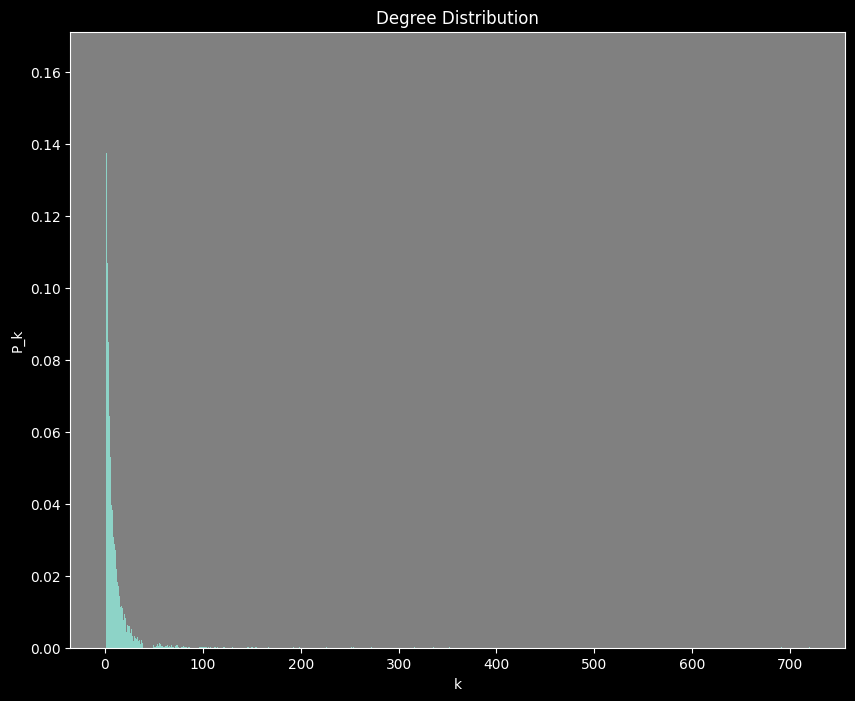

In [19]:
# get degree distribution 
def plot_degree_distribution(graph: nx.Graph):  
    """plot the degree distribution graph"""
    degrees = np.array([degree for node, degree in graph.degree()])
    degree_index, degree_dist = np.unique(degrees, return_counts=True)
    degree_dist = degree_dist / len(graph.nodes)

    temp_list = list(zip(degree_index, degree_dist))
    max_ind, max_val = max(temp_list, key=lambda x: x[1])
    min_ind, min_val = min(temp_list, key=lambda x: x[1])
    print(f"Most probable degree: {(degree_index[max_ind], max_val)}.")
    print(f"Least probable degree: {(degree_index[min_ind], min_val)}.")

    figure = plt.figure(figsize=(10, 8))
    ax = plt.axes()
    ax.set_facecolor('grey')
    plt.bar(degree_index, degree_dist)
    plt.title("Degree Distribution")
    plt.xlabel("k")
    plt.ylabel("P_k")
    plt.show() 

plot_degree_distribution(twitch)

In [24]:
# add feature attributes to nodes 
def add_attributes(graph: nx.Graph, features: pd.DataFrame): 
    """Give nodes in the graph attributes"""
    attributes = features.to_dict(orient='index')
    nx.set_node_attributes(graph, attributes)
    print("Node attributes set.")

add_attributes(twitch, twitch_target)
twitch.nodes[2299]

Node attributes set.


{'id': 73045350,
 'days': 1459,
 'mature': False,
 'views': 9528,
 'partner': False}

In [26]:
# create graph visualization (centrality plot) 
pos = nx.spring_layout(twitch)
between_cent = nx.closeness_centrality(twitch)

In [27]:
# filter the nodes with more than 10000 viewers
node_views = {node: twitch.nodes[node]['views'] for node in twitch.nodes}
nodes_to_plot = [node for node, views in node_views.items() if views >= 10000]
edges_to_plot = [(node1, node2) for node1 in nodes_to_plot for node2 in nodes_to_plot if node1 != node2 and twitch.has_edge(node1, node2)]

In [39]:
# create graph visualization part 2
node_color = [10000.0 * between_cent[v] for v in nodes_to_plot]
node_size =  [between_cent[node]**2 * 20 for node in nodes_to_plot]

(-0.8361679396033287,
 1.0532516917586325,
 -0.8503588140010834,
 0.879645437002182)

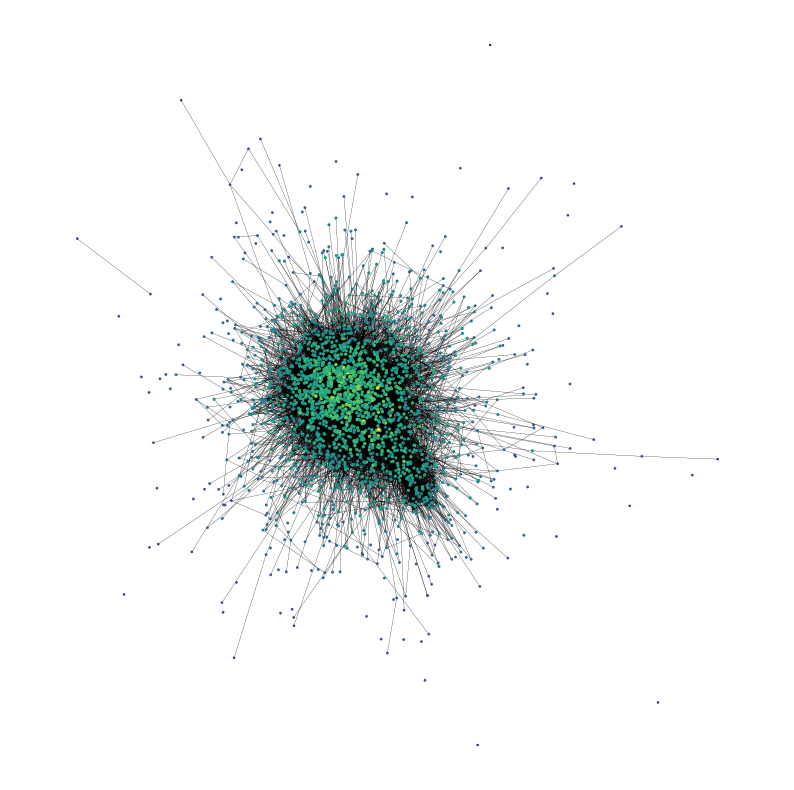

In [40]:
# plot the network graph
figure = plt.figure(figsize=(10,10))
nx.draw_networkx(twitch, 
                    pos=pos, 
                    with_labels=False,
                    node_color=node_color,
                    node_size=node_size,
                    nodelist=nodes_to_plot,
                    edgelist=edges_to_plot,  
                    width=0.1)
figure.set_facecolor('white')
plt.axis('off')

## 2. CORA Exploration 

Goals
- Download the Cora dataset. Read the readme file.
- Construct a graph from the features (word_attributes within cora.content) using one of the methods you learned about in section 2.2 of the von Luxburg tutorial in week 1. You may use sklearn.neighbors in your implementation.
- Construct an adjacency matrix from the citation information given in cora.cites.
- Compare the graph properties of the constructed graph to the given citation graph. Are the graphs similar?

In [3]:
import sklearn.neighbors as nb
import numpy as np